# Building an emotion classifier with OpenAI and Braintrust

In this cookbook, we'll learn how to evaluate the precision and recall of a custom LLM classifier in Braintrust using custom scoring functions. For this cookbook, We'll use the [go_emotions dataset](https://huggingface.co/datasets/google-research-datasets/go_emotions), which contains Reddit comments labeled with 28 different emotions. What makes this dataset particularly interesting is that each comment can be labeled with multiple emotions - for example, a single message might express both "excitement" and "anger".

We'll build two classifiers - a random baseline and an LLM-based approach using OpenAI's GPT-4o. By comparing their performance using custom scorers, we'll demonstrate how to effectively measure then improve your LLM's accuracy on complex classification tasks.

## Getting started

First, you'll need a two accounts:
- [Braintrust](https://www.braintrust.dev/signup) - for running the LLM evaluations
- [OpenAI](https://platform.openai.com/signup) - to use the GPT-4o model. Save your API key in Braintrust because we will be using the Braintrust proxy for this cookbook.


![aiproviders.png](assets/aiproviders.png)

Next, install the required Python packages:

In [ ]:
pip install braintrust openai datasets autoevals

## Setting up the environment

In [ ]:
import os
import random
from typing import List, Dict, Any, Set

import openai
import braintrust
from datasets import load_dataset
from autoevals import *

Configure your Braintrust client:

Replace `YOUR_API_KEY` with your Braintrust API key that you create in the Braintrust dashboard.

<Callout type="info">
 Best practice is to export your API key as an environment variable. However, to make it easier to follow along with this cookbook, we've included it directly in the code.
</Callout>


In [3]:
os.environ["BRAINTRUST_API_KEY"] = "YOUR_API_KEY"

openai_client = braintrust.wrap_openai(
    openai.OpenAI(
        base_url="https://api.braintrust.dev/v1/proxy",
        api_key=os.environ["BRAINTRUST_API_KEY"],
    )
)



## Loading the dataset

First, we'll create helper functions to load the emotion labels and dataset. The `get_emotion_labels` function extracts the emotion column names from the dataset by filtering out metadata columns. This gives us our complete set of possible emotions that we can detect.

The `load_data` function then processes the raw dataset into a format suitable for evaluation. For each comment, it:
1. Extracts the text content
2. Identifies which emotions are present (where the value is 1)
3. Includes relevant metadata like the subreddit and author - Not necessary but included to see how meta data might appear in Braintrust

In [4]:
def get_emotion_labels() -> List[str]:
    ds = load_dataset("google-research-datasets/go_emotions", "raw")

    metadata_columns = {
        "text",
        "id",
        "author",
        "subreddit",
        "link_id",
        "parent_id",
        "created_utc",
        "rater_id",
        "example_very_unclear",
    }
    return sorted(
        col for col in ds["train"].features.keys() if col not in metadata_columns
    )


EMOTIONS: List[str] = get_emotion_labels()


def load_data(limit: int = 100):
    ds = load_dataset("google-research-datasets/go_emotions", "raw")
    for i, item in enumerate(ds["train"]):
        if i >= limit:
            break

        actual_emotions = [emotion for emotion in EMOTIONS if item.get(emotion, 0) == 1]

        yield {
            "input": item["text"],
            "expected": actual_emotions,
            "metadata": {"subreddit": item["subreddit"], "author": item["author"]},
        }

Generating train split: 100%|██████████| 211225/211225 [00:00<00:00, 911049.47 examples/s]


## Creating the classifiers

We'll implement two different approaches to emotion classification:

1. A random baseline classifier that assigns 1-3 emotions randomly from our predefined list, which helps establish a minimum performance threshold and validates our custom scoring mechanisms.

2. An LLM-based classifier using GPT-4o that analyzes the Reddit comments with a prompt containing possible emotions. This classifier returns emotions in a comma-separated format, and includes robust error handling for edge cases.


In [5]:
def random_classifier(text: str) -> List[str]:
    num_emotions = random.randint(1, 3)
    return random.sample(EMOTIONS, num_emotions)


def parse_llm_emotions(raw_response: str) -> List[str]:
    raw_response = raw_response.strip().lower()

    if "," in raw_response:
        candidates = [e.strip() for e in raw_response.split(",")]
    else:
        candidates = [raw_response]

    valid_emotions = [e for e in candidates if e in EMOTIONS and e != ""]
    return valid_emotions


def llm_classifier(text: str) -> List[str]:
    prompt = (
        f"Please identify the emotions present in the following text.\n"
        f"Choose from these emotions: {', '.join(EMOTIONS)}\n"
        f"Multiple emotions may be present.\n\n"
        f"Text: {text}\n\n"
        f"Return only the emotions list with no additional text or explanation."
    )

    try:
        resp = openai_client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": prompt}],
            temperature=0,
        )

        raw_response = resp.choices[0].message.content
        return parse_llm_emotions(raw_response)

    except Exception as e:
        print(f"[llm_classifier] Exception: {e}")
        return []

## Implementing evaluation metrics 

For multi-label classification tasks like emotion detection, we need specialized metrics that can handle multiple correct answers. We implement three key metrics:

`Precision`: Measures how many of the identified emotions are actually correct. For example, if our system predicts "joy" and "anger" for a comment that only expresses "joy", we achieve a precision of 0.5 because only "joy" is correct.
   - High precision means we rarely predict emotions that aren't present
   - Important for applications where false positives are costly

`Recall`: Measures whether we captured all the emotions that were truly present in the Reddit comments. For instance, if a comment expresses both "sadness" and "fear" but we only identify "sadness," we get a recall of 0.5. This is fundamentally different from precision because it tells us if we missed emotions that should have been identified.
   - High recall means we rarely miss emotions that are present
   - Important for applications where false negatives are costly

`F1 Score`: The F1 Score balances precision and recall by calculating their harmonic mean, which is necessary because optimizing for one often comes at the expense of the other. If our LLM achieves high precision, it might be too conservative and miss emotions (low recall). Conversely, if it achieves high recall, it might overidentify emotions (low precision). The F1 score gives us a single metric to evaluate our LLM's overall performance in identifying emotions in Reddit comments.


In [6]:
def emotion_precision(_: str, expected: List[str], output: List[str]) -> float:
    expected_set: Set[str] = set(expected)
    output_set: Set[str] = set(output)

    true_positives: int = len(expected_set & output_set)
    false_positives: int = len(output_set - expected_set)

    denominator = true_positives + false_positives
    if denominator == 0:
        return 0.0
    return true_positives / denominator


def emotion_recall(_: str, expected: List[str], output: List[str]) -> float:
    expected_set: Set[str] = set(expected)
    output_set: Set[str] = set(output)

    true_positives: int = len(expected_set & output_set)
    false_negatives: int = len(expected_set - output_set)

    denominator = true_positives + false_negatives
    if denominator == 0:
        return 0.0
    return true_positives / denominator


def emotion_f1(_: str, expected: List[str], output: List[str]) -> float:
    prec = emotion_precision("", expected, output)
    rec = emotion_recall("", expected, output)

    if (prec + rec) == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

## Running evaluations

Finally, let's set up our evaluation pipeline using Braintrust:

In [ ]:
def run_evaluations(num_samples: int = 100):
    # Random classifier experiment
    braintrust.Eval(
        "emotion-classification-cookbook-jp",  # The name of your project in Braintrust
        data=lambda: load_data(limit=num_samples),
        task=random_classifier,
        scores=[emotion_precision, emotion_recall, emotion_f1],
        metadata={"classifier_type": "random"},
        experiment_name="random-classifier",
    )

    # LLM classifier experiment
    braintrust.Eval(
        "emotion-classification-cookbook-jp",
        data=lambda: load_data(limit=num_samples),
        task=llm_classifier,
        scores=[emotion_precision, emotion_recall, emotion_f1],
        metadata={"classifier_type": "llm", "model": "gpt-4o"},
        experiment_name="llm-classifier",
    )


if __name__ == "__main__":
    run_evaluations(num_samples=100)

## Analyzing the results

Once you run the evaluations, you'll see the results in your Braintrust dashboard. The LLM classifier should significantly outperform the random baseline across all metrics.

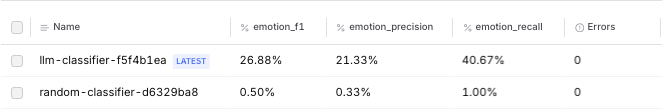

Key features to examine:
- Compare precision and recall scores between our runs
- Look at specific examples where the LLM fails 
- Analyze cases where multiple emotions are present




## Where to go from here

There are several ways to improve this emotion classifier:
- Experiment with different prompts and instructions. Maybe even a series of prompts?
- Try other models like Grok 2 or OpenAI's o1.
- Add more sophisticated scoring functions